In [3]:
import random
import numpy as np
import pandas as pd
from scipy.stats import bernoulli
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.gaussian_process import GaussianProcessRegressor
import torch as th
import torch
import torch.nn as nn
import copy
import warnings
from typing import List, Optional, Tuple
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.gaussian_process.kernels import Kernel
import torch.nn.functional as F
from data_gen_dyn_ts import generate_structure_dynamic
from causal_structure import StructureModel
import statsmodels.api as sm
from scipy.stats import multivariate_normal
from nnlinear_utils import NotearsNonlinear_lag, Tensor
import pandas as pd
from generate_nonlin import gen_stationary_dyn_net_and_df_regime

# Model:

In [4]:
class pi_tn(nn.Module):
            def __init__(self, regime):
                        super(pi_tn, self).__init__()
                        self.regime = regime
                        self.linear = nn.Linear(1,self.regime)
                        
            def forward(self,t):
                        outp = self.linear(t)
                        return outp

In [5]:
def train(num_epochs, model, data, gamma):
            model.train()
            criterion = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            soft = nn.Softmax()
            for _ in range(num_epochs):
                        y_pre = model(data)  
                        loss = criterion(y_pre, gamma)
                        
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
            #print("loss: "+str(loss.item()))
            
            
            return soft(y_pre),loss.item(),model

In [13]:
def CASTOR(X,max_it,lags,window,device):
            n = int(X.shape[1]//2)
            m = X.shape[0]
            N_regime = m//window
            
            for it in range(max_it):
                        
                        model_n = [NotearsNonlinear_lag(w_threshold = 0.1,A_threshold = 0.2, hidden_layers = (10,1),device_type = "gpu")  for _ in range(N_regime)]
                        device = torch.device('cuda:1')
                        yl = np.zeros((m, n , N_regime))
                        if it == 0:
                                    p = np.zeros((m,N_regime))
                                    for c in range(N_regime):
                                                if c  == N_regime -1:
                                                            p[c*window:,c] = np.ones(m-c*window)
                                                            model_n[c].learn(Tensor(X[c*window:,:]))
                                                else:
                                                            p[c*window:(c+1)*window,c] = np.ones(window)
                                                            model_n[c].learn(Tensor(X[c*window:(c+1)*window,:]))
                                                
                        else:
                                    for c in range(N_regime):
                                                gamma = gamma_hat[:,c].reshape((m,1))
                                                model_n[c].learn(Tensor(gamma*X))
                        pall = 0                        
                        gamma_hat = np.zeros((m, N_regime))
                        for class_idx in range(N_regime):
                                    #p[:,class_idx] = model(t)
                                    #yl[:, :, class_idx] = X[:,:n] - X[:,:n].dot(L[:n, :n, class_idx]) - X[:,n:lags*n].dot(L[n:lags*n,:n, class_idx]) 
                                    X_torch = torch.from_numpy(X[:,:n])
                                    Y_torch = torch.from_numpy(X[:,n:lags*n])
                                    X_torch = X_torch.to(device)
                                    Y_torch = Y_torch.to(device)
                                    vector = X_torch - model_n[class_idx].modell(X_torch.float(),Y_torch.float())
                                    yl[:, :, class_idx] = vector.cpu().detach().numpy()
                                    pall = pall + p[:,class_idx] * multivariate_normal.pdf(yl[:, :, class_idx], mean= np.zeros(n),
                                                                                    cov=1*np.eye(n))
                                    gamma_hat[:, class_idx] = p[:,class_idx] * multivariate_normal.pdf(yl[:, :, class_idx], mean= np.zeros(n),
                                                                                    cov=1*np.eye(n))
                        idx = np.argmax(gamma_hat/pall.reshape((m,1)), axis=-1)
                        gamma_hat = np.zeros( gamma_hat.shape )
                        gamma_hat[ np.arange(gamma_hat.shape[0]), idx] = 1
                       
                        if it>=0:
                                 
                                 t = torch.tensor(np.linspace(0,20*N_regime,X.shape[0]).reshape((X.shape[0],1)))
                                 model = pi_tn(N_regime)
                                 p,loss,model_ = train(200,model, t.float(), torch.tensor(gamma_hat).float())
                                 p = p.detach().numpy()
                                 while loss>=0.7:
                                             p,loss,model_ = train(100,model_, t.float(), torch.tensor(gamma_hat).float())
                                             p = p.detach().numpy()
                                 gamma_sum = np.sum(gamma_hat, axis=0) 
                                 gamma_sum[gamma_sum<150] = 0  
                                 indexes, = np.where(gamma_sum!= 0)
                                 gamma_hat = gamma_hat[:,indexes]
                                 p = p[:,indexes]
                                 N_regime = len(indexes)          
                                 print(str(np.sum(gamma_hat, axis=0))+" iter: "+str(it)+" , p: "+str(np.sum(p, axis=0)))
            return gamma_hat, model_n

## Generate data:

In [14]:
def id_(x):
            return x

def leaky_relu(arr):
            alpha = 0.1
            return np.maximum(alpha*arr, arr)

def relu(arr):

            return np.maximum(0, arr)

In [21]:
reg_size = np.random.choice([300,500,600], 3)
reg_size

array([300, 300, 500])

In [24]:
reg_funct = np.random.choice([leaky_relu,np.tanh, relu],3)
reg_funct

array([<ufunc 'tanh'>, <ufunc 'tanh'>, <ufunc 'tanh'>], dtype=object)

In [28]:
g_list,df_total, intra_nodes, inter_nodes = gen_stationary_dyn_net_and_df_regime(3,reg_funct,10,reg_size,1,4,1,w_max_inter=1,w_min_inter=0,
                                                                                 w_max_intra=1,w_min_intra=0,
                                                                                 graph_type_intra = "barabasi-albert",
                                                                                 graph_type_inter = "erdos-renyi",
                                                                                 noise_scale = [1,1,1,1,1],#np.random.uniform(1, 3, 4),
                                                                                 max_data_gen_trials = 1000)

In [29]:
n_nodes = 10
lag = False
if lag == True:
            rearange_intra = [str(i)+"_lag0" for i in range(n_nodes)]
            rearange_inter1 = [str(i)+"_lag1" for i in range(n_nodes)]
            rearange_inter2 = [str(i)+"_lag2" for i in range(n_nodes)]
            rearange_inter = rearange_inter1 + rearange_inter2
else:
            rearange_intra = [str(i)+"_lag0" for i in range(n_nodes)]
            rearange_inter = [str(i)+"_lag1" for i in range(n_nodes)]

In [30]:
X = df_total[rearange_intra+rearange_inter].to_numpy()

gamma_hat, model_n = CASTOR(X, 5, 2, 200,torch.device('cuda:1'))

/tmp/ipykernel_38138/3910170848.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return soft(y_pre),loss.item(),model


[200. 200. 200. 200. 300.] iter: 0 , p: [163.00156 199.29266 199.76318 200.7598  337.18286]
[204. 284. 426.] iter: 1 , p: [166.06245 283.6178  464.19638]
[261. 329. 510.] iter: 2 , p: [180.7192 333.0103 586.2705]
[251. 331. 518.] iter: 3 , p: [161.3501  301.81717 636.8327 ]
[230. 323. 547.] iter: 4 , p: [144.51176 323.07224 632.41595]


## Causal Graph plot:

In [34]:
lags = 2
reg_num = 3
n_nodes = 10
L = np.zeros((lags*n_nodes, lags*n_nodes, reg_num))
for i,class_idx in enumerate(np.array([0,1,2])):#,3,4])):
            L[:n_nodes, :n_nodes, i] = np.array((abs(model_n[class_idx].W_no_thres)>0.05).astype(int)) 
            L[n_nodes:lags*n_nodes,:n_nodes, i] = (abs(model_n[class_idx].A_no_thres)>0.3).astype(int)

In [35]:
def plt_fig(reg,g_list,L, node):
            plt.figure(figsize=(18,10))
                        
            for i in range(reg):
                        
                        plt.subplot(2*reg,2,4*i+1)
                        L1 = L[:node,:node,i]

                        plt.imshow(L1)
                        plt.title("estimated instantaneous graph regime "+str(i+1))

                        plt.subplot(2*reg,2,4*i+2)
                        plt.imshow(nx.to_numpy_array(g_list[i])[node:2*node,node:2*node])
                        plt.title("True instantaneous link regime " +str(i+1))

                        plt.subplot(2*reg,2,4*i+3)
                        L1 = L[node:2*node,:node,i]

                        plt.imshow(L1)
                        plt.title("estimated second graph regime "+str(i+1))

                        plt.subplot(2*reg,2,4*i+4)
                        plt.imshow(nx.to_numpy_array(g_list[i])[:node,node:2*node])
                        plt.title("True Lag graph regime "+str(i+1))
            plt.tight_layout()

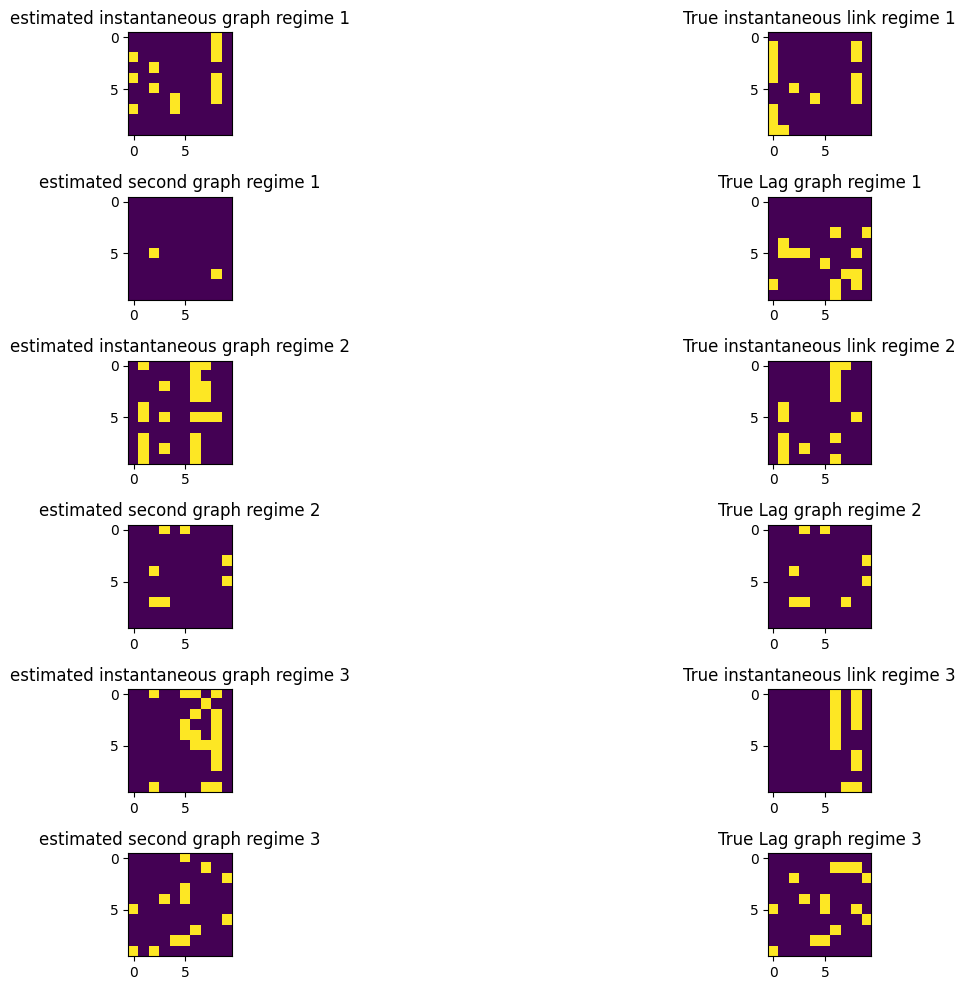

In [36]:
plt_fig(3,g_list,L, 10)